# Assignment 4 Real-time text classification in the browser

### Jing Qian (jq2282)

## Part 2
Modify the starter code (​7-colorbot-predict-starter.ipynb​) to predict color R,G,B values from names.

In [0]:
!pip install -q tensorflow-gpu==2.0.0-alpha0

In [0]:
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import csv
import matplotlib.pyplot as plt
import numpy as np
import os

In [3]:
# Download the colors dataset
if not os.path.exists('colors.csv'):
  !curl -O 'https://raw.githubusercontent.com/random-forests/datasets/master/colors.csv'
!head colors.csv

name,red,green,blue
parakeet,174,182,87
saddle brown,88,52,1
cucumber crush,222,237,215
pool blue,134,194,201
distance,98,110,130
light urple,179,111,246
east side,172,145,206
florida seashells,250,228,199
paris,145,167,189


In [4]:
# Read the data
colors_rgb = []
csv_reader = csv.reader(open('colors.csv'), delimiter=',')
next(csv_reader) # Remove the header
for row in csv_reader:
    name, r, g, b = row[0].lower().strip(), float(row[1]) / 255.0, float(row[2]) / 255.0, float(row[3]) / 255.0
    colors_rgb.append((name, r, g, b))
print(len(colors_rgb), 'colors downloaded')
print('For example', colors_rgb[0])

14157 colors downloaded
For example ('parakeet', 0.6823529411764706, 0.7137254901960784, 0.3411764705882353)


In [0]:
names = [item[0] for item in colors_rgb]

In [6]:
maxlen = 25
t = Tokenizer(char_level=True)
t.fit_on_texts(names)
tokenized = t.texts_to_sequences(names)
print(t.word_index)

padded_names = pad_sequences(tokenized, maxlen=maxlen)
padded_names = padded_names.astype('float32')

vocab_size = len(t.word_index) + 1

{'e': 1, 'a': 2, 'r': 3, ' ': 4, 'i': 5, 'n': 6, 'l': 7, 'o': 8, 't': 9, 's': 10, 'c': 11, 'u': 12, 'd': 13, 'g': 14, 'p': 15, 'h': 16, 'm': 17, 'b': 18, 'y': 19, 'w': 20, 'k': 21, 'f': 22, 'v': 23, 'z': 24, 'q': 25, 'j': 26, 'x': 27}


In [0]:
r = [item[1] for item in colors_rgb]
g = [item[2] for item in colors_rgb]
b = [item[3] for item in colors_rgb]
targets = np.column_stack([r, g, b])

In [8]:
print(names[0])
padded_names[0]

parakeet


array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0., 15.,  2.,  3.,  2., 21.,  1.,  1.,  9.],
      dtype=float32)

In [9]:
# Improve me!
model = tf.keras.Sequential()
model.add(tf.keras.layers.Reshape((1, maxlen), input_shape=(maxlen,)))
model.add(tf.keras.layers.GRU(256, return_sequences=True))
model.add(tf.keras.layers.GRU(128))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(3, activation='sigmoid'))
model.compile('adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 1, 25)             0         
_________________________________________________________________
unified_gru (UnifiedGRU)     (None, 1, 256)            217344    
_________________________________________________________________
unified_gru_1 (UnifiedGRU)   (None, 128)               148224    
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 195       
Total params: 374,019
Trainable params: 374,019
Non-trainable params: 0
_________________________________________________________________


In [10]:
# it's fine if your model massively overfits to the training
# set for thsi experiment
history = model.fit(padded_names, targets, epochs=10, validation_split=0.1)

Train on 12741 samples, validate on 1416 samples
Epoch 1/10
12741/12741 [==============================] - 4s 318us/sample - loss: 0.0627 - val_loss: 0.0642
Epoch 2/10
12741/12741 [==============================] - 3s 221us/sample - loss: 0.0590 - val_loss: 0.0611
Epoch 3/10
12741/12741 [==============================] - 3s 220us/sample - loss: 0.0573 - val_loss: 0.0619
Epoch 4/10
12741/12741 [==============================] - 3s 225us/sample - loss: 0.0558 - val_loss: 0.0595
Epoch 5/10
12741/12741 [==============================] - 3s 221us/sample - loss: 0.0544 - val_loss: 0.0587
Epoch 6/10
12741/12741 [==============================] - 3s 220us/sample - loss: 0.0530 - val_loss: 0.0584
Epoch 7/10
12741/12741 [==============================] - 3s 224us/sample - loss: 0.0515 - val_loss: 0.0574
Epoch 8/10
12741/12741 [==============================] - 3s 217us/sample - loss: 0.0497 - val_loss: 0.0579
Epoch 9/10
12741/12741 [==============================] - 3s 215us/sample - loss: 0.048

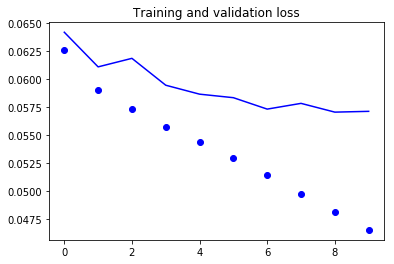

In [11]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'bo')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.show()

In [0]:
# plots a color image
def plot_rgb(rgb):
    data = [[rgb]]
    plt.figure(figsize=(2,2))
    plt.imshow(data, interpolation='nearest')
    plt.axis('off')
    plt.show()

In [0]:
def scale(n):
    return int(n * 255)

In [0]:
def predict(name):
    tokenized = t.texts_to_sequences([name])
    padded = pad_sequences(tokenized, maxlen=maxlen)
    padded = padded.astype('float32')
    pred = model.predict(np.array(padded))[0]
    r, g, b = scale(pred[0]), scale(pred[1]), scale(pred[2])
    print(name + ',', 'R,G,B:', r,g,b)
    plot_rgb(pred)

light blue, R,G,B: 102 146 190


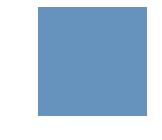

blue, R,G,B: 99 139 168


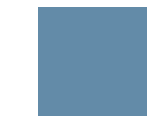

dark blue, R,G,B: 70 108 151


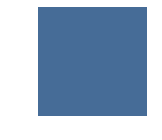

tensorflow orange, R,G,B: 221 99 52


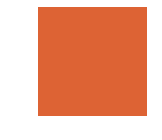

In [15]:
# Hopefully this will improve with your updated model
predict("light blue")
predict("blue")
predict("dark blue")
predict("tensorflow orange")